In [1]:
import pymc

In [2]:
pymc.__version__

'2.3.6'

In [38]:
%matplotlib inline

In [3]:
for i in dir(pymc) :
    if not i.startswith("__") :
        print(i)

AdaptiveMetropolis
ArrayContainer
Bernoulli
Beta
Betabin
BinaryMetropolis
Binomial
Categorical
Cauchy
Chi2
CircVonMises
CircularStochastic
CommonDeterministics
CompletedDirichlet
Container
ContainerBase
ContainerMeta
ContainerRegistry
Container_values
Degenerate
Deterministic
DeterministicBase
DeterministicMeta
DeterministicRegistry
DictContainer
Dirichlet
DiscreteMetropolis
DiscreteUniform
DiscreteUninformative
DrawFromPrior
Exponential
Exponweib
GOFpoints
Gamma
Geometric
Gibbs
HalfCauchy
HalfNormal
Histogram
Hypergeometric
Impute
ImputeMissing
Index
InstantiationDecorators
InvLogit
InverseGamma
Lambda
Laplace
LazyFunction
LinearCombination
ListContainer
Logistic
Logit
Lognormal
MAP
MCMC
Matplot
Metropolis
Model
Multinomial
MultivariateHypergeometric
MvNormal
MvNormalChol
MvNormalCov
NegativeBinomial
NoStepper
Node
NoncentralT
NormApprox
NormApproxC
NormApproxMu
Normal
NormalApproximation
NumpyDeterministics
ObjectContainer
OneOverX
PDMatrixMetropolis
ParentDict
Pareto
Poisson
Potenti

In [4]:
help(pymc)

Help on package pymc:

NAME
    pymc - Markov Chain Monte Carlo sampling toolkit.

DESCRIPTION
    Bayesian estimation, particularly using Markov chain Monte Carlo (MCMC), is an increasingly relevant approach to statistical estimation. However, few statistical software packages implement MCMC samplers, and they are non-trivial to code by hand. pymc is a python package that implements the Metropolis-Hastings algorithm as a python class, and is extremely flexible and applicable to a large suite of problems. pymc includes methods for summarizing output, plotting, goodness-of-fit and convergence diagnostics.
    
    pymc only requires NumPy. All other dependencies such as matplotlib, SciPy, pytables, or sqlite are optional.

PACKAGE CONTENTS
    CircularStochastic
    CommonDeterministics
    Container
    Container_values
    InstantiationDecorators
    LazyFunction
    MCMC
    Matplot
    Model
    Node
    NormalApproximation
    NumpyDeterministics
    PyMCObjects
    ScipyDistributi

## 하나의 파일을 받아서 실제 변수를 생성해 보기

In [67]:
import pymc
import numpy as np

In [70]:
count_data = np.loadtxt('textdata.csv')

n_count_data = len(count_data)

In [76]:
n_count_data

74

In [71]:
alpha = 1.0/count_data.mean()
lambda1 = pymc.Exponential("lambda1",alpha)
lambda2 = pymc.Exponential("lambda2",alpha)

tau = pymc.DiscreteUniform('tau',lower=0,upper=n_count_data)

In [77]:
alpha

0.05065023956194388

In [79]:
lambda1.value

array(0.5288372221112477)

In [80]:
lambda2.value

array(59.493104357042256)

In [74]:
tau.value

array(32)

In [75]:
print('random output',tau.random(),tau.random())

random output 8 53


## 결정함수 지정하기

In [81]:
@pymc.deterministic
def lambda_(tau=tau,lambda1=lambda1, lambda2=lambda2) :
    out = np.zeros(n_count_data)
    out[:tau] = lambda1
    out[tau:] = lambda2
    
    return out

In [82]:
observation = pymc.Poisson('obs',lambda_, value=count_data, observed=True)

In [83]:
model = pymc.Model([observation,lambda1, lambda2, tau])

 [-----------------100%-----------------] 10000 of 10000 complete in 1.0 secPlotting lambda2
Plotting lambda1
Plotting tau


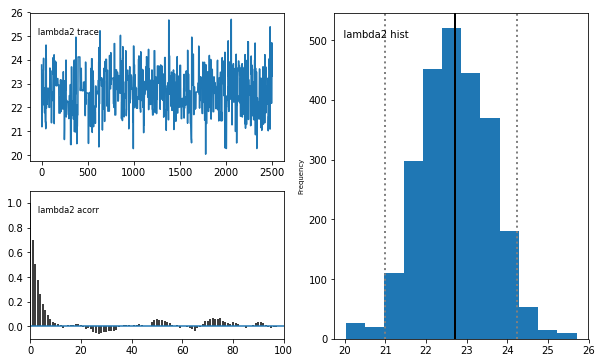

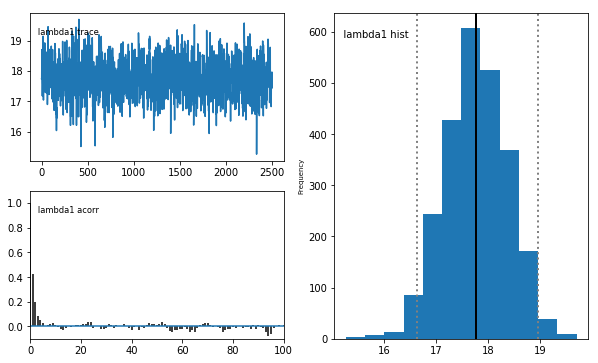

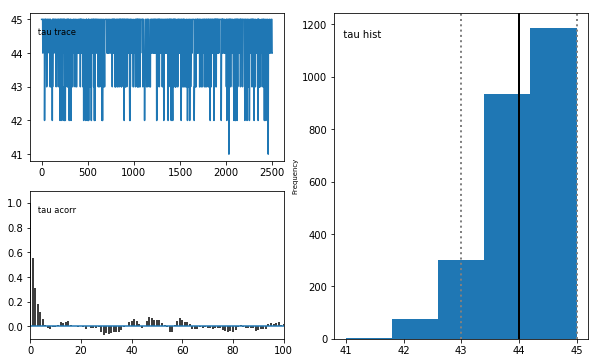

In [84]:
mcmc = pymc.MCMC(model)

mcmc.sample(iter=10000, burn=5000, thin=2)
pymc.Matplot.plot(mcmc)

In [86]:
lambda1_samples = mcmc.trace('lambda1')[:]
lambda2_samples = mcmc.trace('lambda2')[:]
tau_samples = mcmc.trace('tau')[:]

In [88]:
lambda1_samples, lambda1_samples.shape

(array([ 17.74228742,  17.74228742,  18.59247206, ...,  17.90540012,
         17.90540012,  17.76732985]), (2500,))

In [89]:
lambda2_samples, lambda2_samples.shape

(array([ 23.78641008,  21.18984918,  21.18984918, ...,  23.31071335,
         23.31071335,  23.83474307]), (2500,))

In [90]:
tau_samples, tau_samples.shape

(array([45, 45, 45, ..., 44, 44, 44]), (2500,))

## 하나의 파이썬 모듈을 만들어서 모델처리

In [62]:
%%writefile mymodel.py

# Import relevant modules
import pymc
import numpy as np
# Some data
n = 5*np.ones(4,dtype=int)
x = np.array([-.86,-.3,-.05,.73])

# Priors on unknown parameters
alpha = pymc.Normal('alpha',mu=0,tau=.01)
beta = pymc.Normal('beta',mu=0,tau=.01)

# Arbitrary deterministic function of parameters
@pymc.deterministic
def theta(a=alpha, b=beta):
    """theta = logit^{-1}(a+b)"""
    return pymc.invlogit(a+b*x)

# Binomial likelihood for data
d = pymc.Binomial('d', n=n, p=theta, value=np.array([0.,1.,3.,5.]),observed=True)

Writing mymodel.py


 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 secPlotting theta_0
Plotting theta_1
Plotting theta_2
Plotting theta_3
Plotting alpha
Plotting beta


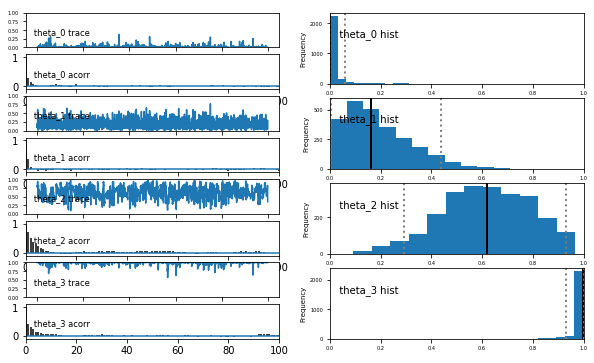

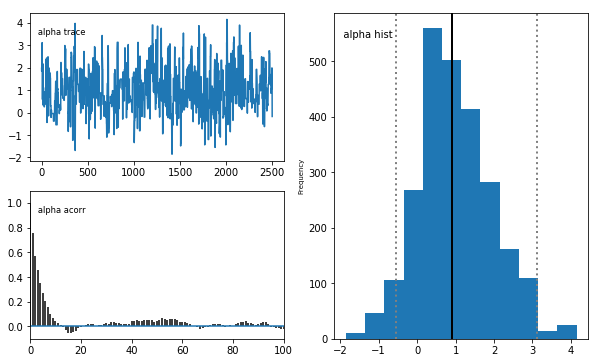

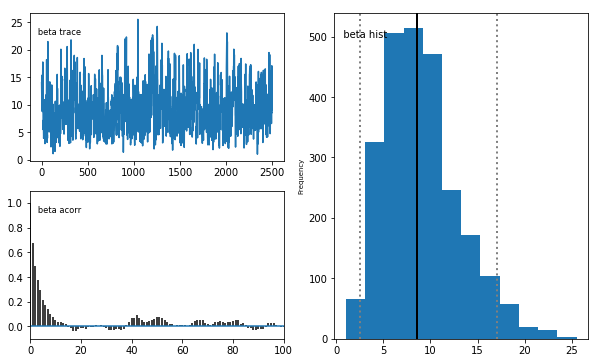

In [63]:
import pymc
import mymodel

S = pymc.MCMC(mymodel, db='pickle')
S.sample(iter=10000, burn=5000, thin=2)
pymc.Matplot.plot(S)